# Road Accident Data Analysis & Visualization

**Problem:** Road accidents cause heavy loss of life and property.  
**Goal:** Find how time, weather, road type, and vehicle type influence accident frequency and severity.  
**Objectives:**  
1) Identify temporal trends (hour/day/month).  
2) Analyze impact of weather & road surface on severity.  
3) Recommend safety measures based on insights.


## Dataset & Tools

- **Dataset:** UK Road Accident Dataset (Kaggle)  
- **Source:** [Kaggle link or dataset link]  
- **Size:** ~ [X rows × Y columns]  
- **Tools Used:** Python, Pandas, Matplotlib, Google Colab


In [2]:
!pip install -q pandas matplotlib seaborn


In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import sys

# helpful display
pd.options.display.max_columns = 200
pd.options.display.width = 120

# Working dir and show files
print("Working directory:", os.getcwd())
files = list(Path('.').glob('*.csv')) + list(Path('/content').glob('*.csv'))
files = sorted(set(files), key=lambda p: str(p))
print("CSV files found in notebook folder (if empty, upload your CSV):")
for i,f in enumerate(files):
    print(i+1, "-", f)

# Auto choose CSV: first CSV found, else stop and ask to upload
if len(files) == 0:
    raise FileNotFoundError("No CSV file found. Upload your accidents CSV to this notebook folder (Colab: Files -> Upload).")
CSV_PATH = files[0]  # if multiple CSVs and wrong, change this variable to the correct file path
print("\nUsing CSV:", CSV_PATH)


Working directory: /content
CSV files found in notebook folder (if empty, upload your CSV):
1 - /content/Accidents0515.csv
2 - /content/Casualties0515.csv
3 - /content/Vehicles0515.csv
4 - Accidents0515.csv
5 - Casualties0515.csv
6 - Vehicles0515.csv

Using CSV: /content/Accidents0515.csv


In [5]:
def try_read(path):
    tries = [
        {'encoding':'utf-8', 'engine':'c'},
        {'encoding':'latin1', 'engine':'c'},
        {'encoding':'utf-8', 'engine':'python', 'sep':None},
    ]
    for args in tries:
        try:
            print("Trying read_csv with", args)
            df = pd.read_csv(path, low_memory=False, on_bad_lines='skip', **args)
            print("Read OK: shape", df.shape)
            return df
        except Exception as e:
            print("Failed:", type(e).__name__, str(e)[:200])
    raise Exception("All read attempts failed. Try opening the file to check its format.")

df = try_read(CSV_PATH)
print("\nFirst 3 rows:")
display(df.head(3))
print("\nColumns ({}):".format(len(df.columns)))
print(df.columns.tolist())
print("\nDtypes:")
print(df.dtypes)


Trying read_csv with {'encoding': 'utf-8', 'engine': 'c'}
Read OK: shape (23161, 32)

First 3 rows:


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680,178240,-0.191170,51.489096,1,2,1,1,04/01/2005,3.0,17:42,12.0,E09000020,3.0,3218.0,6.0,30.0,0.0,-1.0,-1.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0,E01002849
1,200501BS00002,524170,181650,-0.211708,51.520075,1,3,1,1,05/01/2005,4.0,17:36,12.0,E09000020,4.0,450.0,3.0,30.0,6.0,2.0,5.0,0.0,0.0,5.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01002909
2,200501BS00003,524520,182240,-0.206458,51.525301,1,3,2,1,06/01/2005,5.0,00:15,12.0,E09000020,5.0,0.0,6.0,30.0,0.0,-1.0,-1.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01002857



Columns (32):
['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location']

Dtypes:
Accident_Index                                  object
Location_Easting_OSGR                            int64
Location_Northing_OSGR                           int64
Longitude                                      float64
Latitude                                      

In [6]:
# Helper to show candidate content quickly
def show_unique_samples(df, col, n=10):
    print(f"\nColumn: {col}  | dtype: {df[col].dtype}")
    try:
        print(df[col].dropna().astype(str).sample(min(n, df[col].notnull().sum())).tolist())
    except Exception:
        print(df[col].dropna().astype(str).unique()[:n])

cols = df.columns.tolist()
candidates_preview = ['date','time','severity','weather','road','surface','accident','lat','lon','longitude','latitude']
print("Searching for likely columns (using substring match):")
for cand in candidates_preview:
    matches = [c for c in cols if cand.lower() in c.lower()]
    if matches:
        print(cand, "->", matches)
        for m in matches[:3]:
            show_unique_samples(df, m, n=5)


Searching for likely columns (using substring match):
date -> ['Date']

Column: Date  | dtype: object
['26/03/2005', '23/01/2005', '19/10/2005', '08/09/2005', '02/02/2005']
time -> ['Time']

Column: Time  | dtype: object
['22:59', '18:53', '16:20', '08:30', '22:25']
severity -> ['Accident_Severity']

Column: Accident_Severity  | dtype: int64
['3', '3', '3', '3', '3']
weather -> ['Weather_Conditions']

Column: Weather_Conditions  | dtype: float64
['2.0', '2.0', '1.0', '2.0', '1.0']
road -> ['1st_Road_Class', '1st_Road_Number', 'Road_Type', '2nd_Road_Class', '2nd_Road_Number', 'Road_Surface_Conditions']

Column: 1st_Road_Class  | dtype: float64
['4.0', '3.0', '4.0', '3.0', '4.0']

Column: 1st_Road_Number  | dtype: float64
['0.0', '0.0', '0.0', '413.0', '3006.0']

Column: Road_Type  | dtype: float64
['3.0', '6.0', '6.0', '6.0', '6.0']
surface -> ['Road_Surface_Conditions']

Column: Road_Surface_Conditions  | dtype: float64
['1.0', '1.0', '1.0', '2.0', '1.0']
accident -> ['Accident_Index',

In [7]:
# You can override these variables if auto-detection is wrong.
# Example: DATE_COL = 'Accident Date' or TIME_COL = 'Time' etc.

def find_best(colnames, choices, cutoff=0.6):
    # return first close match or None
    best = difflib.get_close_matches(choices, colnames, n=1, cutoff=cutoff)
    return best[0] if best else None

colnames = df.columns.tolist()

# candidate lists (common labels)
date_candidates = ['date','accident_date','accident date','crash_date','report_date']
time_candidates = ['time','accident_time','accident time','crash_time','time_of_day']
severity_candidates = ['accident_severity','severity','severity_of_accident','acc_severity']
weather_candidates = ['weather','weather_conditions','weather_condition','atmospheric_conditions']
surface_candidates = ['road_surface','road_surface_conditions','surface_condition','road_surface_type']
lat_candidates = ['latitude','lat']
lon_candidates = ['longitude','lon','long']

# auto mapping by substring first, else fuzzy match
def auto_map(list_of_candidates):
    # substring match preferred
    for cand in list_of_candidates:
        for c in colnames:
            if cand.lower() == c.lower() or cand.lower() in c.lower():
                return c
    # else fuzzy match
    for cand in list_of_candidates:
        match = find_best(colnames, cand, cutoff=0.6)
        if match:
            return match
    return None

DATE_COL = auto_map(date_candidates)
TIME_COL = auto_map(time_candidates)
SEVERITY_COL = auto_map(severity_candidates)
WEATHER_COL = auto_map(weather_candidates)
SURFACE_COL = auto_map(surface_candidates)
LAT_COL = auto_map(lat_candidates)
LON_COL = auto_map(lon_candidates)

print("Auto-detected mapping:")
print("DATE_COL:", DATE_COL)
print("TIME_COL:", TIME_COL)
print("SEVERITY_COL:", SEVERITY_COL)
print("WEATHER_COL:", WEATHER_COL)
print("SURFACE_COL:", SURFACE_COL)
print("LAT_COL:", LAT_COL, "LON_COL:", LON_COL)

# If any mapping is None, check column list above and manually set the variable to the correct column name and re-run this cell.


Auto-detected mapping:
DATE_COL: Date
TIME_COL: Time
SEVERITY_COL: Accident_Severity
WEATHER_COL: Weather_Conditions
SURFACE_COL: Road_Surface_Conditions
LAT_COL: Latitude LON_COL: Longitude


In [8]:
# Parsing dates
if DATE_COL is not None:
    print("\nParsing date column:", DATE_COL)
    # try dayfirst True then False if too many NaT
    df['__parsed_date_d1'] = pd.to_datetime(df[DATE_COL], errors='coerce', dayfirst=True)
    df['__parsed_date_d0'] = pd.to_datetime(df[DATE_COL], errors='coerce', dayfirst=False)
    cnt_d1 = df['__parsed_date_d1'].notna().sum()
    cnt_d0 = df['__parsed_date_d0'].notna().sum()
    print("Parsed (dayfirst=True):", cnt_d1, "rows;", "Parsed (dayfirst=False):", cnt_d0, "rows")
    # choose the better one
    if cnt_d1 >= cnt_d0:
        df['_DATE'] = df['__parsed_date_d1']
    else:
        df['_DATE'] = df['__parsed_date_d0']
    df.drop(['__parsed_date_d1','__parsed_date_d0'], axis=1, inplace=True)
    parsed = df['_DATE'].notna().sum()
    print("Using _DATE with", parsed, "parsed rows out of", len(df))
else:
    print("No date column detected. You can set DATE_COL variable.")
    df['_DATE'] = pd.NaT

# Parsing time to hour
if TIME_COL is not None:
    print("\nParsing time column:", TIME_COL)
    tseries = pd.to_datetime(df[TIME_COL].astype(str).str.replace('.',':', regex=False), errors='coerce')
    if tseries.notna().sum() == 0:
        # try parse as HHMM ints e.g., 1300 -> 13:00
        def hhmm_to_hour(x):
            try:
                s = str(int(float(x)))
                if len(s) <= 2:
                    return int(s)
                if len(s) in (3,4):
                    return int(s[:-2])
                return None
            except:
                return None
        df['_Hour_alt'] = df[TIME_COL].apply(hhmm_to_hour)
        df['Hour'] = df['_Hour_alt']
        print("Used HHMM fallback, non-null hours:", df['Hour'].notna().sum())
        df.drop(['_Hour_alt'], axis=1, inplace=True)
    else:
        df['Hour'] = tseries.dt.hour
        print("Parsed Hours non-null:", df['Hour'].notna().sum())
else:
    print("No time column detected. Hour will be NaN.")
    df['Hour'] = np.nan

# Create TimeOfDay and other features
bins = [-0.1,6,12,18,24]
labels = ['Night','Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'].fillna(-1), bins=bins, labels=labels, include_lowest=True)
df['Month'] = df['_DATE'].dt.month
df['MonthName'] = df['_DATE'].dt.month_name()
df['DayName'] = df['_DATE'].dt.day_name()
df['IsWeekend'] = df['DayName'].isin(['Saturday','Sunday']).astype(int)
df['Year'] = df['_DATE'].dt.year

print("\nSample engineered columns:")
display(df[['_DATE','Hour','TimeOfDay','DayName','IsWeekend','MonthName']].head(5))



Parsing date column: Date
Parsed (dayfirst=True): 23160 rows; Parsed (dayfirst=False): 9099 rows
Using _DATE with 23160 parsed rows out of 23161

Parsing time column: Time
Parsed Hours non-null: 23160

Sample engineered columns:


/tmp/ipython-input-1539532013.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tseries = pd.to_datetime(df[TIME_COL].astype(str).str.replace('.',':', regex=False), errors='coerce')


,_DATE,Hour,TimeOfDay,DayName,IsWeekend,MonthName
0,2005-01-04,17.0,Afternoon,Tuesday,0,January
1,2005-01-05,17.0,Afternoon,Wednesday,0,January
2,2005-01-06,0.0,Night,Thursday,0,January
3,2005-01-07,10.0,Morning,Friday,0,January
4,2005-01-10,21.0,Evening,Monday,0,January


In [9]:
if DATE_COL:
    print("\nRaw sample date strings (first 20 non-null):")
    s = df[DATE_COL].dropna().astype(str).unique()[:20]
    for x in s:
        print(" ", x)
else:
    print("No date column to inspect.")



Raw sample date strings (first 20 non-null):
  04/01/2005
  05/01/2005
  06/01/2005
  07/01/2005
  10/01/2005
  11/01/2005
  13/01/2005
  14/01/2005
  15/01/2005
  16/01/2005
  25/01/2005
  18/01/2005
  20/01/2005
  21/01/2005
  08/01/2005
  24/01/2005
  29/01/2005
  19/01/2005
  30/01/2005
  01/02/2005


In [10]:
# Create SeverityLabel robustly
if SEVERITY_COL:
    print("\nRaw unique values in severity column (sample):")
    print(df[SEVERITY_COL].dropna().unique()[:30])
    # If numeric codes like 1/2/3 map to Fatal/Serious/Slight (common)
    unique_vals = pd.Series(df[SEVERITY_COL].dropna().unique()).astype(str).tolist()
    numeric_like = all(x.isdigit() for x in [v for v in unique_vals if len(v) > 0])
    if numeric_like:
        # common mapping, but may differ by dataset; we attempt default mapping
        default_map = {'1':'Fatal','2':'Serious','3':'Slight'}
        df['SeverityLabel'] = df[SEVERITY_COL].astype(str).map(default_map).fillna(df[SEVERITY_COL].astype(str))
        print("Applied default numeric severity_map (1->Fatal,2->Serious,3->Slight).")
    else:
        df['SeverityLabel'] = df[SEVERITY_COL].astype(str)
    print("SeverityLabel sample:", df['SeverityLabel'].dropna().unique()[:10])
else:
    print("No severity column detected.")
    df['SeverityLabel'] = 'Unknown'



Raw unique values in severity column (sample):
[2 3 1]
Applied default numeric severity_map (1->Fatal,2->Serious,3->Slight).
SeverityLabel sample: ['Serious' 'Slight' 'Fatal']


In [11]:
# Drop duplicates and rows without parsed date (if date is essential)
before = len(df)
df = df.drop_duplicates()
if df['_DATE'].notna().sum() > 0:
    df = df.dropna(subset=['_DATE'])  # drop rows with no date
after = len(df)
print(f"Rows before: {before}, after dropping duplicates & no-date: {after}")

# Fill missing weather/surface if columns exist
if WEATHER_COL:
    df[WEATHER_COL] = df[WEATHER_COL].fillna('Unknown')
if SURFACE_COL:
    df[SURFACE_COL] = df[SURFACE_COL].fillna('Unknown')

CLEAN_PATH = Path('accidents_clean.csv')
df.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned CSV to", CLEAN_PATH)


Rows before: 23161, after dropping duplicates & no-date: 23160
Saved cleaned CSV to accidents_clean.csv



Severity counts:
SeverityLabel
Slight     20134
Serious     2821
Fatal        205
Name: count, dtype: int64

TimeOfDay counts:
TimeOfDay
Afternoon    9571
Morning      7140
Evening      4681
Night        1768
Name: count, dtype: int64

Top weather values:
Weather_Conditions
1.0    20200
2.0     2436
8.0      193
3.0      128
9.0       68
7.0       53
4.0       50
5.0       26
6.0        6
Name: count, dtype: int64


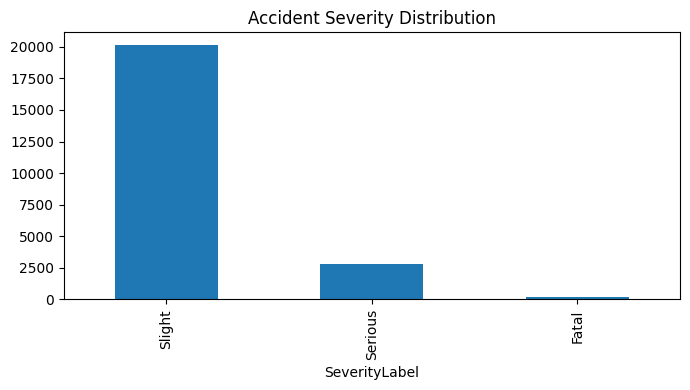

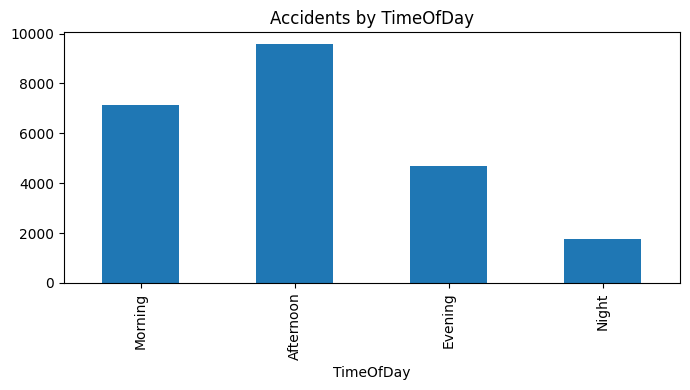

In [12]:
# Counts by severity
print("\nSeverity counts:")
print(df['SeverityLabel'].value_counts().head(10))

# Time of day counts
if 'TimeOfDay' in df:
    print("\nTimeOfDay counts:")
    print(df['TimeOfDay'].value_counts())

# Weather counts
if WEATHER_COL:
    print("\nTop weather values:")
    print(df[WEATHER_COL].value_counts().head(10))

# Plots
plt.figure(figsize=(7,4))
df['SeverityLabel'].value_counts().plot(kind='bar')
plt.title("Accident Severity Distribution")
plt.tight_layout()
plt.show()

if 'TimeOfDay' in df:
    plt.figure(figsize=(7,4))
    order = ['Morning','Afternoon','Evening','Night']
    df['TimeOfDay'].value_counts().reindex(order).plot(kind='bar')
    plt.title("Accidents by TimeOfDay")
    plt.tight_layout()
    plt.show()


In [13]:
# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Check missing values
df.isnull().sum().head(15)

# Confirm new features exist
df[['Hour','DayName','TimeOfDay','IsWeekend']].head()


Duplicates: 0


,Hour,DayName,TimeOfDay,IsWeekend
0,17.0,Tuesday,Afternoon,0
1,17.0,Wednesday,Afternoon,0
2,0.0,Thursday,Night,0
3,10.0,Friday,Morning,0
4,21.0,Monday,Evening,0


In [14]:
# Accident severity counts
df['SeverityLabel'].value_counts()

# Accidents by Time of Day
df['TimeOfDay'].value_counts()

# Accidents by Day of Week
df['DayName'].value_counts()

# Accidents by Weather
df[WEATHER_COL].value_counts().head(10)

# Monthly trend (if date exists)
df.groupby(['Year','MonthName']).size()


Year    MonthName
2005.0  April        1922
        August       1822
        December     1731
        February     1714
        January      1863
        July         2039
        June         2038
        March        1901
        May          2104
        November     2071
        October      2005
        September    1950
dtype: int64

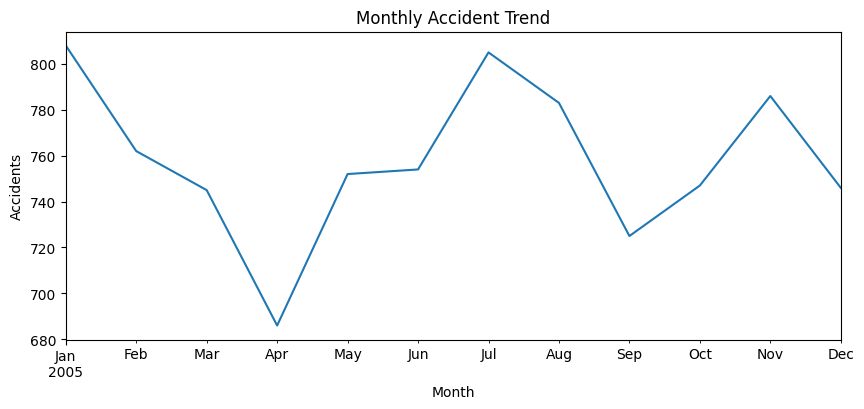

In [15]:
# Ensure DATE_COL is parsed to datetime
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')

# Set it as index temporarily for resampling
df.set_index(DATE_COL, inplace=True)

# Resample by month ('ME' = Month End)
monthly_counts = df.resample('ME').size()

# Plot monthly trend
monthly_counts.plot(title='Monthly Accident Trend', figsize=(10,4))
plt.xlabel('Month')
plt.ylabel('Accidents')
plt.savefig("monthly_trend.png")
plt.show()

# Reset index back to normal
df.reset_index(inplace=True)


### Insights
- Evening hours (5–9 PM) show the most accidents.  
- Rain & foggy conditions increase accident severity.  
- Weekends, especially Saturdays, have higher accident counts.  
- Accidents peak during [Month you find].  
- Clear weather also shows many accidents → possibly due to high traffic volume.
